# Skew correction of Passport using pythonRLSA

Importing required libraries

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

## Image preprocessing for passport image

In [14]:
# function to show images in specified size
def imShow(image):
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    #plt.rcParams['figure.figsize'] = [10, 5]
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# function to adjust the brightness through gamma parameter
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# image processing fuction return gray scale image
def image_processing_passport_front(img):
    kernel = np.ones((7,7), np.uint8)
    dilated_img = cv2.dilate(img, kernel)
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(img, bg_img)
    norm_img = diff_img.copy() # Needed for 3.x compatibility
    norm_img = cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 200, 0, cv2.THRESH_TRUNC)
    norm_img = cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    adjusted = adjust_gamma(norm_img, gamma=0.5)
    gray=cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
    return gray


## skew correction code

Here are the steps to follow:

1. Resize image to particular size that will help to filter best connnected components later
2. Image preprocessing
3. Converting to image binary 0 or 1
4. Apply block segmentation and text descrimination using pythonRLSA "https://pypi.org/project/pythonRLSA/"
5. Inverse the binary image using opencv thresh_binary_inv method
6. Apply opencv connectedComponentsWithStats method to obtain the stats of each connected component
7. Use stats to find out angle of rotation of the selected CC
8. Filter out the best connected components by iterating through each component
9. Finding wether angle is positive or negative 
10. Compensating the skew angle

### 1. Resizing an image to a particular size

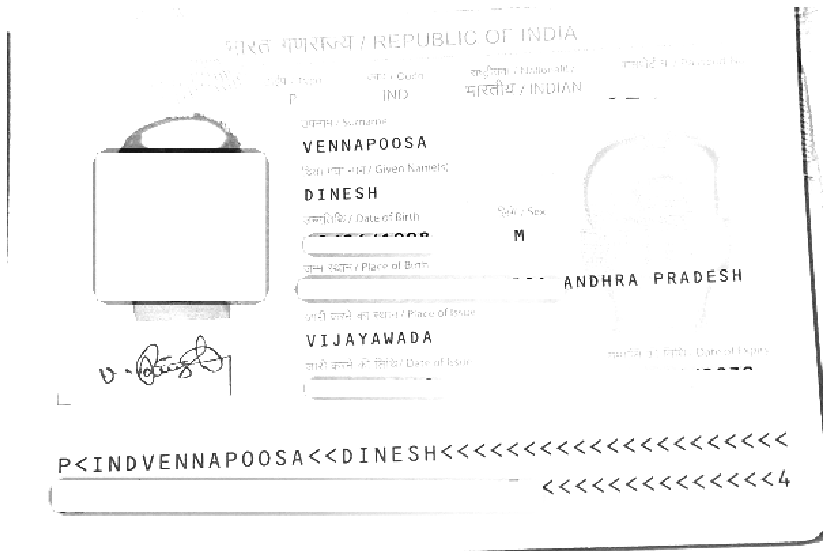

357.9519540963528


C:\Users\Dinesh\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


In [25]:
# 1. Resizing an image to a particular size
img='passport_front_copy.jpg'
image = cv2.imread(img)
image = cv2.resize(image, (600, 400))

# 2. Image preprocessing
gray = image_processing_passport_front(image)
imShow(gray)
# 3. Converting to gray image to binary 0 or 1
(thresh, image_binary) = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 4. Apply block segmentation and text descrimination using pythonRLSA
from pythonRLSA import rlsa
image_rlsa_horizontal = rlsa.rlsa(image_binary, True, False,30)

# 5. Inverse the binary image using opencv thresh_binary_inv method which we can
#    extract the stats of that component
(thresh, image_rlsa_horizontal_inv) = cv2.threshold(image_rlsa_horizontal,0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# 6. Applying opencv connectedComponentsWithStats method to obtain the stats of each connected component
output = cv2.connectedComponentsWithStats(image_rlsa_horizontal_inv, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

# 7. Use stats to find out angle of rotation, width, height of the selected CC asuming the shape of the cc as rectangle
count=0
sum_angle=0
positive_skew=[]
negative_skew=[]
# loop over the number of unique connected component labels
for i in range(0, numLabels):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    if i == 0:
        text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
    # otherwise, we are examining an actual connected component
    else:
        text = "examining component {}/{}".format( i + 1, numLabels)
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH] # width of the rectangle bounded to the connected component
        h = stats[i, cv2.CC_STAT_HEIGHT]# height of the rectangle bounded to the connected componet
        area = stats[i, cv2.CC_STAT_AREA] # area of the connected component(CC)
        (cX, cY) = centroids[i] # centroid of the CC
        componentMask = (labels == i).astype("uint8") * 255
        # calculating the height and width of the CC and its anlge of rotation 
        rectangle_area=w*h
        y_connected=h-((rectangle_area-area)/w)
        x_connected=area/y_connected
        alpha=x_connected/y_connected

        xm,ym=(x,y+(y_connected/2))
        a=(cY-ym)/(cX-xm)

        radian=math.atan(a)

        angle=radian*(180/math.pi)
# 8. Filter out the best connected components by iterating through each component
        if w>=400 and alpha>=30:
            sum_angle+=angle
            count+=1
            output = image_rlsa_horizontal.copy()
            componentMask = (labels == i).astype("uint8") * 255

            componentMask_copy=componentMask.copy()
            cv2.rectangle(componentMask_copy, (x, y), (x + w, y + h), (255, 255, 255), 1)
            cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 1)
            white_list=[]
            black_list=[]
            for i in range(int(xm),int(cX)):
                y_line=int(a*(float(i)-xm)+ym)
                x_line=int(i)

                if componentMask[y_line,x_line]==255:         
                    white_list.append(255)

                elif componentMask[y_line,x_line]==0:
                        black_list.append(0)
                    #cv2.circle(componentMask_copy, (x_line,y_line), radius=0, color=(255, 255, 255), thickness=0)
                if len(black_list)>len(white_list):
                    positive_skew.append('True')
                else:
                    negative_skew.append('True')

# 9. Finding wether angle is positive or negative                    
avg_skew_angle=sum_angle/count    
if len(positive_skew)>len(negative_skew):           
        rotation_angle=360-avg_skew_angle
else:
    rotation_angle=avg_skew_angle
print(rotation_angle)

# 10. Compensating the skew angle
skew_allowable=0.5
if avg_skew_angle>skew_allowable:
    image=cv2.imread(img)
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), rotation_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

## All in one

In [18]:
def skew_correction_passport(img):
    image = cv2.imread(img)
    image = cv2.resize(image, (600, 400))
    gray = image_processing_passport_front(image)
    (thresh, image_binary) = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # function call
    from pythonRLSA import rlsa
    image_rlsa_horizontal = rlsa.rlsa(image_binary, True, False,30)
    (thresh, image_rlsa_horizontal_inv) = cv2.threshold(image_rlsa_horizontal,0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    imShow(image_rlsa_horizontal_inv)
    output = cv2.connectedComponentsWithStats(image_rlsa_horizontal_inv, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    count=0
    sum_angle=0
    positive_skew=[]
    negative_skew=[]
    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        if i == 0:
            text = "examining component {}/{} (background)".format(
                i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format( i + 1, numLabels)
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            (cX, cY) = centroids[i]
            componentMask = (labels == i).astype("uint8") * 255
            rectangle_area=w*h
            y_connected=h-((rectangle_area-area)/w)
            x_connected=area/y_connected
            alpha=x_connected/y_connected
            
            xm,ym=(x,y+(y_connected/2))
            a=(cY-ym)/(cX-xm)

            radian=math.atan(a)

            angle=radian*(180/math.pi)

            if w>=400 and alpha>=30:
                sum_angle+=angle
                count+=1
                output = image_rlsa_horizontal.copy()
                componentMask = (labels == i).astype("uint8") * 255

                componentMask_copy=componentMask.copy()
                cv2.rectangle(componentMask_copy, (x, y), (x + w, y + h), (255, 255, 255), 1)
                cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 1)
                white_list=[]
                black_list=[]
                for i in range(int(xm),int(cX)):
                    y_line=int(a*(float(i)-xm)+ym)
                    x_line=int(i)

                    if componentMask[y_line,x_line]==255:         
                        white_list.append(255)

                    elif componentMask[y_line,x_line]==0:
                        black_list.append(0)
                    #cv2.circle(componentMask_copy, (x_line,y_line), radius=0, color=(255, 255, 255), thickness=0)
                if len(black_list)>len(white_list):
                    positive_skew.append('True')
                else:
                    negative_skew.append('True')

    avg_skew_angle=sum_angle/count    
    if len(positive_skew)>len(negative_skew):           
            rotation_angle=360-avg_skew_angle
    else:
        rotation_angle=avg_skew_angle
    print(rotation_angle)
    skew_allowable=0.5
    if avg_skew_angle>skew_allowable:
        image=cv2.imread(img)
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        # rotate our image by 45 degrees around the center of the image
        M = cv2.getRotationMatrix2D((cX, cY), rotation_angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        return rotated
    else:
        return image
    

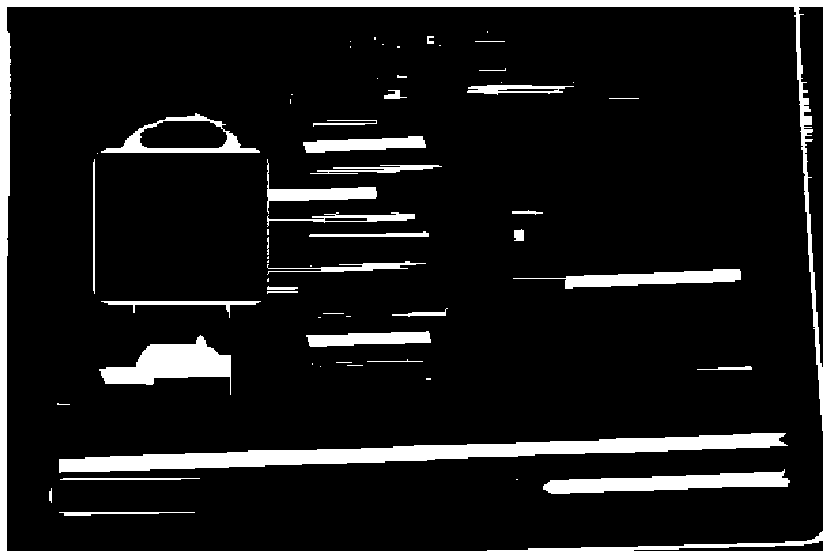

C:\Users\Dinesh\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


357.9519540963528


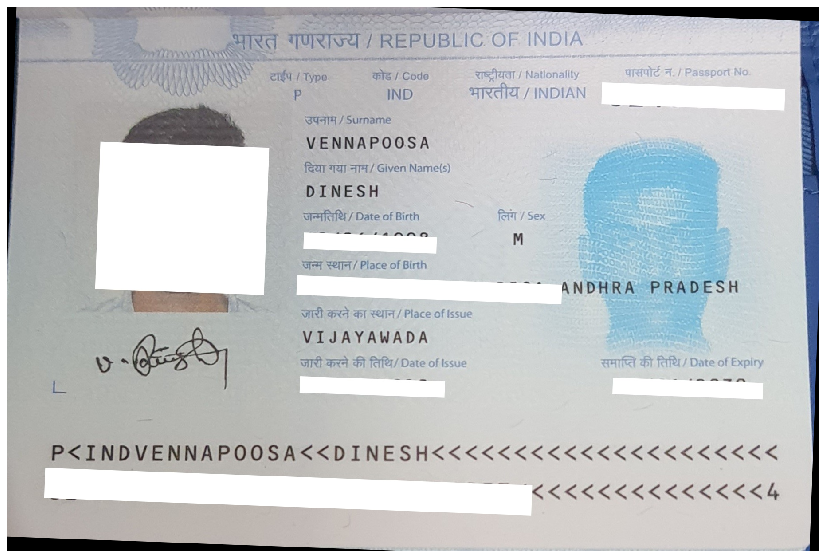

In [23]:
res=skew_correction_passport('passport_front_copy.jpg')
imShow(res)

# Upload your own document ,do custom image preprocessing and will give better results